In [4]:
from petitRADTRANS import Radtrans
import petitRADTRANS.retrieval_examples.emission.master_retrieval_model as rm
from petitRADTRANS import nat_cst as nc
import petitRADTRANS.rebin_give_width as rgw
from scipy.interpolate import interp1d
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)


from torch.distributions import Independent, Distribution
sys.path.insert(1, '/home/mvasist/scripts/')
from fab_priors import BoxUniform_New

import torch
from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat


retrieval_name = 'JWST_emission_petitRADTRANSpaper'
absolute_path = 'output1/'# end with forward slash!
op= '/home/mvasist/petitRADTRANS/petitRADTRANS/retrieval_examples/emission/'
observation_files = {}
# observation_files['NIRISS SOSS'] = op +'NIRISS_SOSS_flux.dat'
# observation_files['NIRSpec G395M'] = op +'NIRSpec_G395M_flux.dat'
observation_files['MIRI LRS'] = op +'MIRI_LRS_flux.dat'

# Wavelength range of observations, fixed parameters that will not be retrieved
WLENGTH = [0.3, 15.0]
# LOG_G =  2.58
R_pl =   1.84*nc.r_jup_mean
R_star = 1.81*nc.r_sun
gamma = 1
t_equ= 0
# Get host star spectrum to calculate F_pl / F_star later.
T_star = 6295.
x = nc.get_PHOENIX_spec(T_star)
fstar = interp1d(x[:,0], x[:,1])
   
####################################################################################
####################################################################################
### READ IN OBSERVATION
####################################################################################
####################################################################################

# Read in data, convert all to cgs!

data_wlen = {}
data_flux_nu = {}
data_flux_nu_error = {}
data_wlen_bins = {}

for name in observation_files.keys():
    print(name)
    dat_obs = np.genfromtxt(observation_files[name])
    data_wlen[name] = dat_obs[:,0]*1e-4
    data_flux_nu[name] = dat_obs[:,1]
    data_flux_nu_error[name] = dat_obs[:,2]

    data_wlen_bins[name] = np.zeros_like(data_wlen[name])
    data_wlen_bins[name][:-1] = np.diff(data_wlen[name])
    data_wlen_bins[name][-1] = data_wlen_bins[name][-2]
    
    
def Simulator(params): 

    NaN_spectra = 0

    atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', \
                                         'CO2', 'CH4', \
                                          'Na', 'K'], \
          rayleigh_species = ['H2', 'He'], \
          continuum_opacities = ['H2-H2', 'H2-He'], \
          wlen_bords_micron = [0.3, 15])#, mode='c-k')


    pressures = np.logspace(-6, 2, 100)
    atmosphere.setup_opa_structure(pressures)
    temperature = 1200. * np.ones_like(pressures)

    
    t_int = params[0].numpy()                             #200.
    log_kappa_IR = params[1].numpy()                      #-2
    log_gravity = params[2].numpy()                       #params[5].numpy() 1e1**2.45 

    gravity = np.exp(log_gravity)
    kappa_IR = np.exp(log_kappa_IR)
    
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, t_int, t_equ)
    
    abundances = {}
    abundances['H2'] = 0.75 * np.ones_like(temperature) #0.74 * np.ones_like(temperature) (params[3].numpy())
    abundances['He'] = 0.25 * np.ones_like(temperature)  #0.24 * np.ones_like(temperature) (params[4].numpy())
    abundances['H2O'] = 0.001 * np.ones_like(temperature)
    abundances['CO_all_iso'] = 0.01 * np.ones_like(temperature)
    abundances['CO2'] = 0.00001 * np.ones_like(temperature)
    abundances['CH4'] = 0.000001 * np.ones_like(temperature)
    abundances['Na'] = 0.00001 * np.ones_like(temperature)
    abundances['K'] = 0.000001 * np.ones_like(temperature)

    MMW = rm.calc_MMW(abundances) * np.ones_like(temperature)
    #print(MMW, abundances)
    
    atmosphere.calc_flux(temperature, abundances, gravity, MMW)

    wlen, flux_nu = nc.c/atmosphere.freq, atmosphere.flux/1e-6


    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(flux_nu)) > 0:
        print("NaN spectrum encountered")
        NaN_spectra += 1
        return torch.ones([1,371])* -np.inf

    # Convert to observation for emission case
    flux_star = fstar(wlen)
    flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 

    flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
                data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])

    #flux_rebinned = np.reshape(flux_rebinned, (371,1))    

    FR= torch.Tensor(flux_rebinned)
    
    return FR    


MIRI LRS


In [5]:
# observation = Simulator([torch.ones(1)*1.5,torch.ones(1)*750.,torch.ones(1)*2000., torch.ones(1)*0.74, \
#                          torch.ones(1)*0.24, torch.ones(1)*np.exp(2.45), torch.ones(1)*0.01])
observation = Simulator([torch.ones(1)*750,torch.ones(1)*-2.,torch.ones(1)*2.58])


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



In [6]:
observation

tensor([1053.2163, 1079.7252, 1106.5704, 1114.3883, 1135.2157, 1136.3796,
        1165.9824, 1163.9946, 1180.6650, 1212.9110, 1185.7970, 1231.8154,
        1236.7041, 1278.8025, 1311.2932, 1368.2617, 1344.4310, 1453.2354,
        1475.0321, 1493.2058, 1552.0011, 1549.0497, 1581.4828, 1583.4569,
        1518.4055, 1421.8916, 1349.7006, 1293.8495, 1211.9515, 1158.5317,
        1191.2804, 1271.7653, 1243.0426, 1240.5101, 1233.8151, 1248.1403,
        1295.7853, 1330.8970, 1376.8029, 1323.0421, 1342.7062, 1289.9531,
        1378.9613, 1410.7173, 1354.9138, 1364.8306, 1352.7961, 1343.4548,
        1368.2250, 1441.0481, 1400.2974, 1448.2278, 1476.5735, 1480.2354,
        1478.5128, 1392.9747, 1489.0046, 1419.5800, 1421.0360, 1348.7645,
        1444.7976, 1429.5165, 1496.0287, 1431.3527, 1452.4332, 1545.7810,
        1474.1512, 1572.0148, 1568.2745, 1570.9081, 1563.0826, 1638.9364,
        1589.0237, 1543.5105, 1591.2904, 1630.9772, 1627.8746, 1591.7473,
        1617.3633, 1538.1355, 1719.418

In [7]:
torch.save(observation, '3param_observation_TintkIRLg.pt')

In [11]:
# observation

In [1]:
# temp_params = {}
# temp_params['log_delta'] = -5.5
# temp_params['log_gamma'] = np.log10(0.4)
# temp_params['t_int'] = 750.
# temp_params['t_equ'] = 0.
# temp_params['log_p_trans'] = -3.
# temp_params['alpha'] = -0.25
# pressures, temperature = nc.make_press_temp(temp_params)

# # Create the Ratrans object here
# rt_object = Radtrans(line_species=['H2O', 'CO_all_iso', \
#                                          'CO2', 'CH4', \
#                                           'Na', 'K'], \
#                     rayleigh_species=['H2','He'], \
#                     continuum_opacities = ['H2-H2','H2-He'], \
#                     mode='c-k', \
#                     wlen_bords_micron=WLENGTH)

# # Create the RT arrays of appropriate lengths
# rt_object.setup_opa_structure(pressures)

# def Simulator_paul(params): 
#     ##################

#     NaN_spectra = 0
    
#     log_gamma = params[0].numpy()[0]                            #log(0.4)
#     t_equ = params[1].numpy()[0]                                #1500.
#     log_gravity = params[2].numpy()[0]                                #params[5] 2.45 
    
#     # Make dictionary for modified Guillot parameters
#     temp_params['log_gamma'] = log_gamma
#     temp_params['t_equ'] = t_equ
    
#     log_P0 = -2.                                      #params[6] 
  
#     gravity = np.exp(log_gravity)
#     P0 = np.exp(log_P0)
#     gamma = np.exp(log_gamma)

    
#     # Make dictionary for log 'metal' abundances    
#     abundances_metals = {}
        
#     abundances_metals['H2O'] = -3              #np.exp(params[7]) * np.ones_like(temperature)
#     abundances_metals['CO_all_iso'] = -2       #np.exp(params[8]) * np.ones_like(temperature)
#     abundances_metals['CO2'] = -5              #np.exp(params[9]) * np.ones_like(temperature)
#     abundances_metals['CH4'] = -6              #np.exp(params[10]) * np.ones_like(temperature)
#     abundances_metals['Na'] = -5               #np.exp(params[11]) * np.ones_like(temperature)
#     abundances_metals['K'] = -6                #np.exp(params[12]) * np.ones_like(temperature)
    
#     ####################################################################
#     ####################################################################

    
#     wlen, flux_nu = \
#             rm.retrieval_model_plain(rt_object, temp_params, log_gravity, \
#                                          log_P0, R_pl, abundances_metals)
# #     flux_nu = flux_nu/1e-6
    
#     # Just to make sure that a long chain does not die
#     # unexpectedly:
#     # Return -inf if forward model returns NaN values
#     if np.sum(np.isnan(flux_nu)) > 0:
#         print("NaN spectrum encountered")
#         NaN_spectra += 1
#         return -np.inf    

#     # Convert to observation for emission case
#     flux_star = fstar(wlen)
#     flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 
    
#     # Rebin model to observation
#     flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
#                     data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])
    
#     FR= torch.Tensor(flux_rebinned)
    
#     p2, t2 = nc.make_press_temp(temp_params)
    
#     return FR



In [ ]:
# observation = Simulator_paul([torch.ones(1)*1.5,torch.ones(1)*2000.,torch.ones(1)*2.58])


In [12]:
a=[]
for i in range(1000):
    a.append(-4 + 4*np.random.uniform(size=1)[0])

(array([102.,  92.,  89.,  96.,  99., 112., 104., 100., 105., 101.]),
 array([-3.99694986e+00, -3.59732190e+00, -3.19769395e+00, -2.79806599e+00,
        -2.39843804e+00, -1.99881008e+00, -1.59918213e+00, -1.19955417e+00,
        -7.99926215e-01, -4.00298260e-01, -6.70304009e-04]),
 <BarContainer object of 10 artists>)

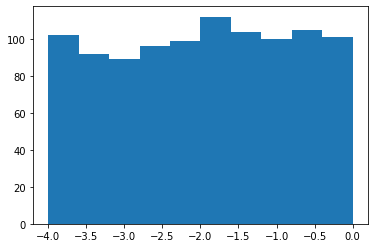

In [13]:
plt.hist(a)